## **Install PyPi packages which is not in Google Colab**

In [1]:
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=8dc3716be540af9e91a186f8e2659569859eae40437dfef66aaeb7b27eaae8a0
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


## **Import necessory python libraries for machine learning & data pre-processing**

In [41]:
import numpy as np
import pandas as pd
import xgboost as xgb
import spacy
import nltk
import re
import pickle
import swifter
import gensim

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Visualization
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn for feature extraction & modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# Iteratively read files
import glob
import os

# For displaying images in ipython
import seaborn as sns
sns.set(color_codes = True)
%matplotlib inline

nltk.download('stopwords')

from google.colab import drive

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Mounting Google drive to download reviews dataset**

In [4]:
drive.mount('drive')

Mounted at drive


## **Loading dataset into Pandas dataframe and removing unwanted columns**

In [5]:
df = pd.read_csv('drive/MyDrive/sentiment.csv', encoding='unicode_escape')
df = df.drop(["ProductName", "ProductPrice", "Sentiment"], axis=1)

<ipython-input-5-ba1eaeb00539>:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('drive/MyDrive/sentiment.csv', encoding='unicode_escape')


In [ ]:
df.shape

(171380, 3)

## **Checking distribution of ratings accross the dataset**

In [6]:
df['Rate'].value_counts()

5                                                               56717
1                                                               28338
5.0                                                             23419
4                                                               19619
3                                                               16909
2                                                                9488
4.0                                                              8185
1.0                                                              4649
3.0                                                              2874
2.0                                                              1180
Pigeon Favourite Electric Kettle??????(1.5 L, Silver, Black)        1
Name: Rate, dtype: int64

## **Fixing rating data to valid data format**

In [7]:
df.loc[df['Rate'] == 5.0 , 'Rate'] = 5
df.loc[df['Rate'] == 4.0  , 'Rate'] = 4
df.loc[df['Rate'] == 1.0 , 'Rate'] = 1
df.loc[df['Rate'] == 3.0 , 'Rate'] = 3
df.loc[df['Rate'] == 2.0 , 'Rate'] = 2
df.loc[df['Rate'] == '5' , 'Rate'] = 5
df.loc[df['Rate'] == '4'  , 'Rate'] = 4
df.loc[df['Rate'] == '1' , 'Rate'] = 1
df.loc[df['Rate'] == '3' , 'Rate'] = 3
df.loc[df['Rate'] == '2' , 'Rate'] = 2
df = df[df.Rate != 'Pigeon Favourite Electric Kettle??????(1.5 L, Silver, Black)']

df = df.dropna(subset=['Rate', 'Summary', 'Review'])

df = df.astype({'Rate':'int'})

In [8]:
df['Rate'].value_counts()

5    80136
1    32987
4    27804
3    19783
2    10668
Name: Rate, dtype: int64

<Axes: >

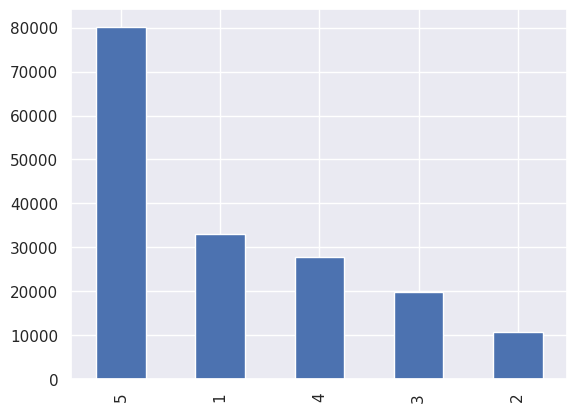

In [9]:
df.Rate.value_counts().plot(kind='bar')

## **Using under sampling technique to balance dataset for better accuracy**

In [10]:
df_majority_5 = df[df.Rate==5]
df_majority_4 = df[df.Rate==4]
df_majority_1 = df[df.Rate==1]

df_majority_downsampled_5 = resample(df_majority_5,
                                 replace=False,
                                 n_samples=20000,
                                 random_state=123)

df_majority_downsampled_4 = resample(df_majority_4,
                                 replace=False,
                                 n_samples=20000,
                                 random_state=123)

df_majority_downsampled_1 = resample(df_majority_1,
                                 replace=False,
                                 n_samples=20000,
                                 random_state=123)

df = df[df.Rate != 5]
df = df[df.Rate != 4]
df = df[df.Rate != 1]

df = pd.concat([df_majority_downsampled_5, df_majority_downsampled_4, df_majority_downsampled_1, df])

In [11]:
df['Rate'].value_counts()

5    20000
4    20000
1    20000
3    19783
2    10668
Name: Rate, dtype: int64

<Axes: >

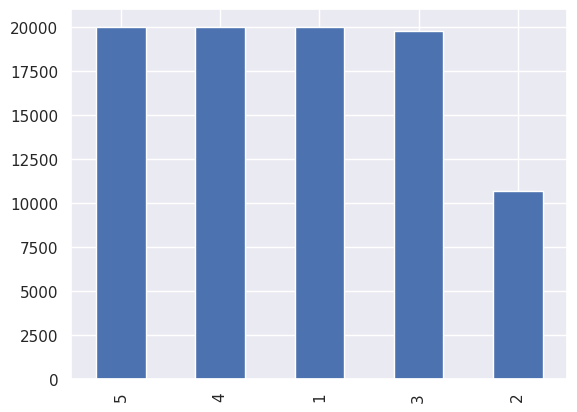

In [12]:
df.Rate.value_counts().plot(kind='bar')

## **Combining Review and Summary to get lengthy input**

In [13]:
df['full_text'] = df["Review"] + ' ' + df["Summary"]

## **Checking how word cloud looks like for each rating category**

In [15]:
heading_1 = df[df["Rate"]==1]["full_text"]
collapsed_heading_1 = heading_1.str.cat(sep=' ')

heading_2 = df[df["Rate"]==2]["full_text"]
collapsed_heading_2 = heading_2.str.cat(sep=' ')

heading_3 = df[df["Rate"]==3]["full_text"]
collapsed_heading_3 = heading_3.str.cat(sep=' ')

heading_4 = df[df["Rate"]==4]["full_text"]
collapsed_heading_4 = heading_4.str.cat(sep=' ')

heading_5 = df[df["Rate"]==5]["full_text"]
collapsed_heading_5 = heading_5.str.cat(sep=' ')

Word Cloud for Rating 1


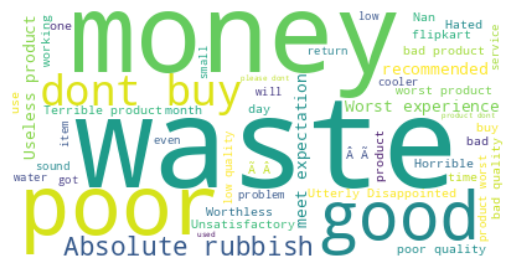


Word Cloud for Rating 2


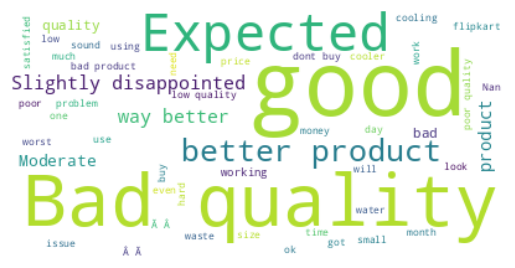


Word Cloud for Rating 3


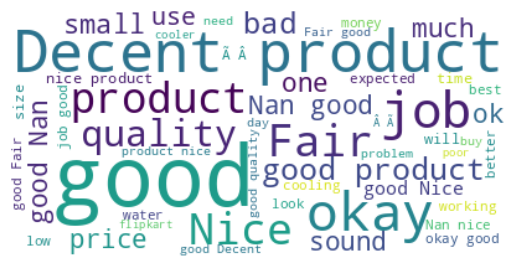


Word Cloud for Rating 4


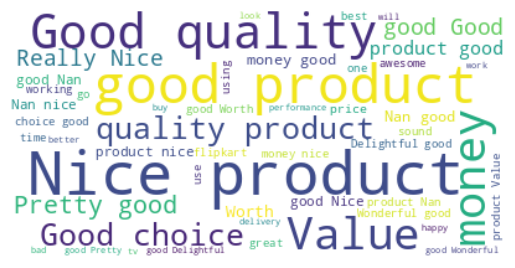


Word Cloud for Rating 5


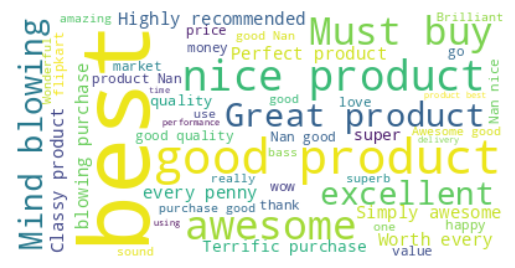

In [16]:
stopwords = set(STOPWORDS)

print("Word Cloud for Rating 1")
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_1)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("\nWord Cloud for Rating 2")
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_2)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("\nWord Cloud for Rating 3")
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_3)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("\nWord Cloud for Rating 4")
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_4)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("\nWord Cloud for Rating 5")
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_words=50).generate(collapsed_heading_5)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Checking for NaN values and removing if exists**

In [17]:
df_1 = df.dropna()
df_1.shape , df.shape

((90451, 4), (90451, 4))

## **Creating data pre-processing pipeline to clean data**

In [20]:
nlp = spacy.load("en_core_web_sm")
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across','among','beside','however','yet','within'])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

def removeStopWords(sentence):
    return re_stop_words.sub(" ", sentence)

def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext

def cleanPunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n"," ")
    return cleaned

def keepAlpha(sentence):
    alpha_sent = ""
    for word in sentence.split():
        alpha_word = re.sub('[^a-z A-Z]+', ' ', word)
        alpha_sent += alpha_word
        alpha_sent += " "
    alpha_sent = alpha_sent.strip()
    return alpha_sent

def lemmatize_words(sentence):
  lemmatized_words = [doc.lemma_.strip() for doc in nlp(sentence)]
  return ' '.join([word for word in lemmatized_words if word not in stop_words and len(word) > 1 and len(word) < 25])

In [31]:
def clean_text(input_df):
  input_df['Cleaned'] = input_df['full_text'].str.lower()
  input_df['Cleaned'] = input_df['Cleaned'].swifter.apply(cleanHtml)
  input_df['Cleaned'] = input_df['Cleaned'].swifter.apply(cleanPunc)
  input_df['Cleaned'] = input_df['Cleaned'].swifter.apply(keepAlpha)
  input_df['Cleaned'] = input_df['Cleaned'].swifter.apply(removeStopWords)
  input_df['Cleaned'] = input_df['Cleaned'].swifter.apply(stemming)

  return input_df

In [22]:
df = clean_text(df)
df.head()

,Rate,Review,Summary,full_text,Cleaned
15296,5,Awesome,awesome thanks flipkart,Awesome awesome thanks flipkart,awesom awesom thank flipkart
47650,5,Nan,nice,Nan nice,nan nice
124401,5,Brilliant,very good product very fast charging,Brilliant very good product very fast charging,brilliant good product fast charg
60927,5,Nan,really nice,Nan really nice,nan realli nice
138567,5,Mind-blowing purchase,perfect,Mind-blowing purchase perfect,mind blow purchas perfect


## **Splitting training & testing dataset**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(df["Cleaned"], df["Rate"], random_state = 42, test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape

((72360,), (18091,), (72360,))

## **Training Naive Bayes model**

In [24]:
naive_bayes_model = Pipeline([
  ('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('classifier', MultinomialNB()),
])

In [25]:
naive_bayes_model = naive_bayes_model.fit(X_train, y_train)

In [26]:
print("Accuracy of Naive Bayes Classifier is {}".format(naive_bayes_model.score(X_test, y_test)))

Accuracy of Naive Bayes Classifier is 0.7960311757227351


In [37]:
text = "Very Good"
input_df = pd.DataFrame([{"full_text": text}])
input_df = clean_text(input_df)
y_predicted = naive_bayes_model.predict([input_df['Cleaned'][0]])
y_predicted[0]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

4

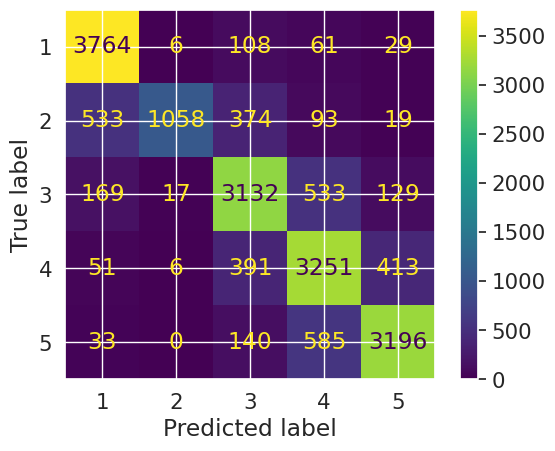

In [72]:
y_actu = y_test
y_pred = naive_bayes_model.predict(X_test)
cf_metrix = confusion_matrix(y_actu, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_metrix, display_labels = [1,2,3,4,5])

cm_display.plot()
plt.show()

In [38]:
with open('drive/MyDrive/model-naive-bayes-final.pkl', 'wb') as file:
  pickle.dump(naive_bayes_model, file)

## **Training Random Forest model**

In [39]:
random_forest_model = Pipeline([
  ('vect', CountVectorizer()),
  ('tfidf', TfidfTransformer()),
  ('classifier', RandomForestClassifier(n_jobs= -1)),
])

random_forest_model = random_forest_model.fit(X_train, y_train)
print("Accuracy of Random Forest Classifier is {}".format(random_forest_model.score(X_test, y_test)))

Accuracy of Random Forest Classifier is 0.863191642253054


In [76]:
text = "Not bad. Good for money"
input_df = pd.DataFrame([{"full_text": text}])
input_df = clean_text(input_df)
y_predicted = random_forest_model.predict([input_df['Cleaned'][0]])
y_predicted[0]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

4

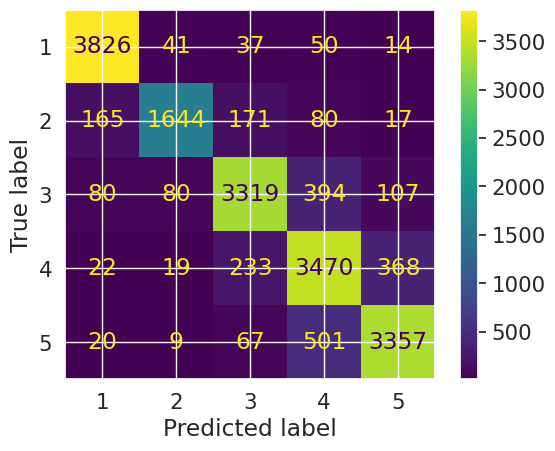

In [77]:
y_actu = y_test
y_pred = random_forest_model.predict(X_test)
cf_metrix = confusion_matrix(y_actu, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_metrix, display_labels = [1,2,3,4,5])

cm_display.plot()
plt.show()

In [78]:
with open('drive/MyDrive/model-random-forest-final.pkl', 'wb') as file:
  pickle.dump(random_forest_model, file)

## **Training XGB Regressor model**

In [79]:
xgb_regressor_model = Pipeline([
  ('vect', CountVectorizer(stop_words= "english")),
  ('tfidf', TfidfTransformer()),
  ('classifier', xgb.XGBRegressor()),
])

xgb_regressor_model = xgb_regressor_model.fit(X_train, y_train)
print("Accuracy of XGB Regressor is {}".format(xgb_regressor_model.score(X_test, y_test)))

Accuracy of XGB Regressor is 0.8530591544555243


In [81]:
text = "This cover is a piece of junk and very thin. I had just bought a new I-pad and wanted a new cover to protect it if dropped. I only had the iPad 1 month when it fell on my laminate floor off of the edge of my couch. Now there is a chip in the corner of my iPad and 2 long broken lines across it. I am so upset and can’t believe I now have a broken screen. Worthless piece of junk as far as protection"
input_df = pd.DataFrame([{"full_text": text}])
input_df = clean_text(input_df)
y_predicted = xgb_regressor_model.predict([input_df['Cleaned'][0]])
round(y_predicted[0])

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

1

In [83]:
with open('drive/MyDrive/model-xgb-regressor-final.pkl', 'wb') as file:
  pickle.dump(xgb_regressor_model, file)

## **Training KNN model**

In [84]:
knn_model = Pipeline([
  ('vect', CountVectorizer(stop_words= "english")),
  ('tfidf', TfidfTransformer()),
  ('classifier', KNeighborsClassifier()),
])

knn_model = knn_model.fit(X_train, y_train)
print("Accuracy of KNN is {}".format(knn_model.score(X_test, y_test)))

Accuracy of KNN is 0.724227516444641


In [85]:
text = "Really cheaply made. How is this the best seller? I will be returning it and will never recommend to anyone. Certainly makes me have less confidence in Amazon"
input_df = pd.DataFrame([{"full_text": text}])
input_df = clean_text(input_df)
y_predicted = knn_model.predict([input_df['Cleaned'][0]])
y_predicted[0]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/1 [00:00<?, ?it/s]

1

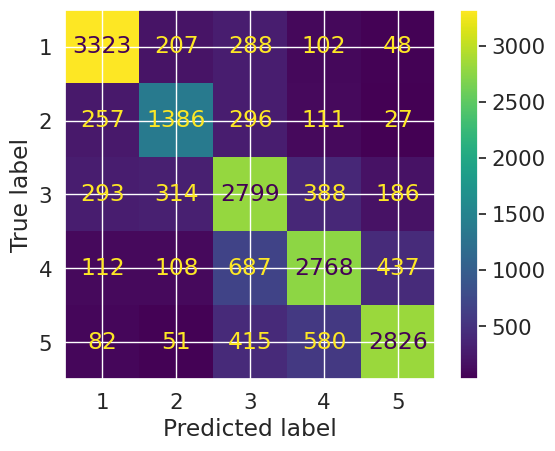

In [86]:
y_actu = y_test
y_pred = knn_model.predict(X_test)
cf_metrix = confusion_matrix(y_actu, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cf_metrix, display_labels = [1,2,3,4,5])

cm_display.plot()
plt.show()

In [87]:
with open('drive/MyDrive/model-knn-final.pkl', 'wb') as file:
  pickle.dump(knn_model, file)

## **What to improve?**


### **Dataset**
We can use more accurate dataset to further improve our accuracy. Current dataset only has reviews for one category of products. Therefore if we can find dataset with more distributed reviews amoung multiple categories, we can improve our results. Also current dataset may have reviews with invalid labels. For example, "Very good product" can be labeled as rating 2. So we need to further analyze dataset for better results

### **TFIDF (Term Frequency & Invert Document Frequency)**
Currently, we are using default sklearn's default text transformer. We can try text transformers such as BERT or Twitter embeddings to transform our text which may give us very good results.

### **Model Algorithm**
In this research, we are testing only few types of ML algorithms which are better for NLP related work. We can try algorithms such as bi-directional language model algorithm.
